In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-28 00:27:38.165386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-28 00:27:38.165421: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
import scanpy as sc

babel_dir = '../babel_data/DM_rep4/'
train = sc.read_h5ad(babel_dir + 'train_rna.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_rna.h5ad').X.toarray()
data1 = np.concatenate([train, valid], axis=0)
fnames1 = np.array(v)

train = sc.read_h5ad(babel_dir + 'train_atac.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_atac.h5ad').X.toarray()
data2 = np.concatenate([train, valid], axis=0)
fnames2 = np.array(v)

split = train.shape[0]

/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
dataset_name = 'DM_rep4'
modality_names = ['RNA', 'ATAC']

# data1 = PCA(n_components=32).fit_transform(data1)
# data2 = PCA(n_components=32).fit_transform(data2)
# fnames1 = fnames2 = None

type1 = np.array(len(data1) * ['Cell Type 0'])
type2 = np.array(len(data2) * ['Cell Type 0'])

# Sampling
# sample_num = 500
# data_col_idx = np.random.choice(range(split), sample_num, replace=False)
# data1, data2, type1, type2 = (x[list(data_col_idx) + list(range(split, len(data1)))] for x in (data1, data2, type1, type2))
# split = sample_num

# Labels
labels = [type1, type2]
features = [np.array(fnames1), np.array(fnames2)]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

In [6]:
# Train-Test Imputation
train_idx = np.array(list(range(split)))
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [7]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 1024
pca_dim = [256] * 2
dist_method = 'euclidean'

# ComManDo

In [8]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2500,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
    'loss_weights': [1,1,1,1],
}
fromChar = [' ', '),', '(', ')', ',', '\'', '[', ']']
toChar = ['', '--', '', '', '-', '', '(', ')']
kwargs_str = str(sorted(kwargs.items()))[1:-1]
for f, t in zip(fromChar, toChar):
    kwargs_str = kwargs_str.replace(f, t)
hash_str = '---'.join([dataset_name, '-'.join([str(s) for s in dataset[0].shape]), '-'.join([str(s) for s in dataset[1].shape]), kwargs_str])

In [9]:
# Imputation
cm_im = ComManDo(**kwargs)
model_str = 'saved_models/cm_im---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
    cm_im.save_model(model_str)
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (3877, 34861)
Dataset 1: (3877, 85596)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:2.8908 alpha:0.7862
epoch:[1000/2000] err:0.0001 alpha:0.0000
epoch:[1500/2000] err:0.0000 alpha:0.0000
epoch:[2000/2000] err:0.0000 alpha:0.0000
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2500]: loss:46.162807
epoch:[1000/2500]: loss:30.286530
epoch:[1500/2500]: loss:24.413822
epoch:[2000/2500]: loss:17.570930
epoch:[2500/2500]: loss:15.400387
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 140.87645544297993
Correspondence: 4071.592922502081
Mapping: 446.2174571650103
Total: 4658.686835110071



# Comparison Methods

In [10]:
# Imputation
if True:
    imputation_name = 'Babel'
    bdata1 = sc.read_h5ad(babel_dir + 'atac_rna_test_preds.h5ad').X.toarray()
    bdata2 = sc.read_h5ad(babel_dir + 'rna_atac_test_preds.h5ad').X.toarray()
    nn_imputed = [bdata1, bdata2]
else:
    imputation_name = 'Dual Autoencoder'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [11]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

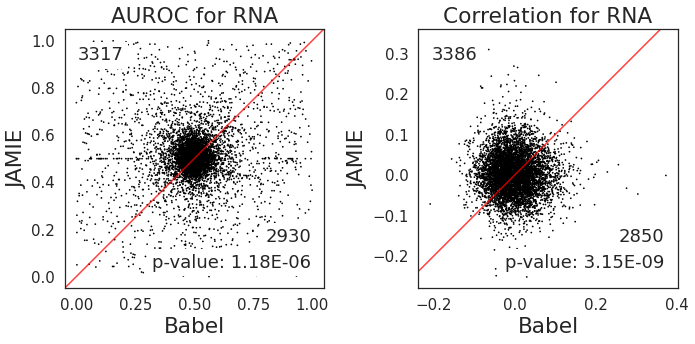

In [12]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300)

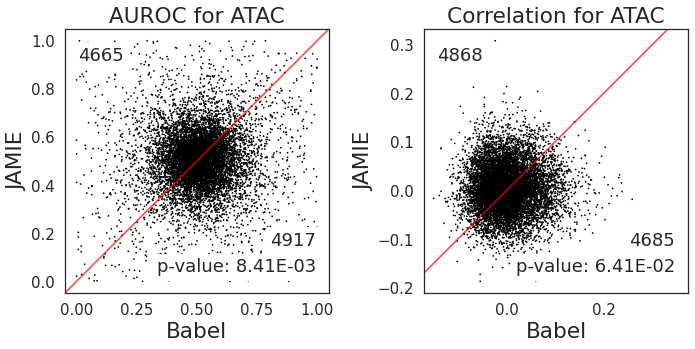

In [13]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png', dpi=300)

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


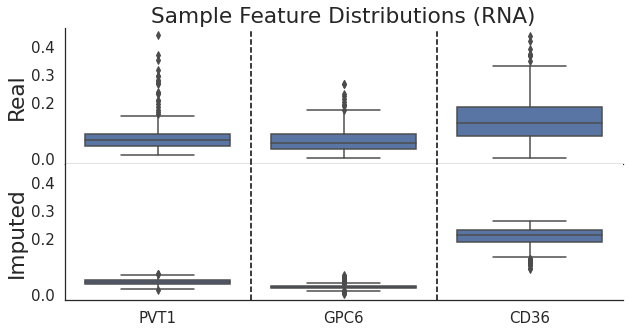

In [14]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300)

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


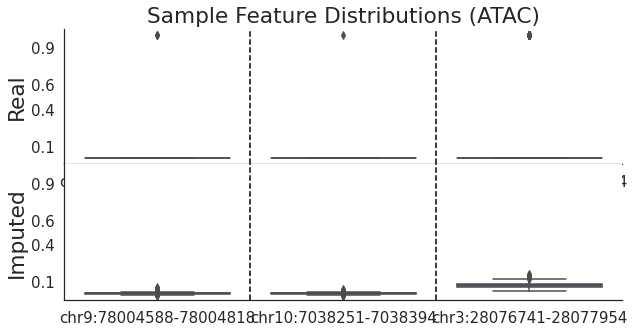

In [15]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300)

# Explanation

In [16]:
mod0, mod1 = 1, 0

In [17]:
from commando.utilities import sort_by_interest

order, interest = sort_by_interest([cm_imputed[mod1], dataset[mod1][test_idx]], limit=10)
order_str = ', '.join([str(n) for n in order[:10]])
order_names_str = ', '.join(features[mod1][order[:10]])
print(f'Top performing features:\n{order_names_str}\n{order_str}')
print()
interest_str = ', '.join([str(n) for n in interest[:10]])
interest_names_str = ', '.join(features[mod1][interest[:10]])
print(f'Top interesting features:\n{interest_names_str}\n{interest_str}')

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Top performing features:
PVT1, CD36, GPC6, MARCKS, CDX2, MYC, ANO4, SNX1, RNF43, CEP112
33330, 31186, 9244, 29886, 8800, 33329, 8140, 11582, 15280, 15401

Top interesting features:
PVT1, CD36, GPC6, MARCKS, CDX2, MYC, ANO4, SNX1, RNF43, CEP112
33330, 31186, 9244, 29886, 8800, 33329, 8140, 11582, 15280, 15401


In [20]:
from scipy import stats

# Omit one testing
in_data = dataset[mod0].copy()
target = interest[0]
out_data = dataset[mod1][:, target]
current_cm = cm_im

background = in_data.mean(0)
logits = current_cm.modal_predict(in_data, mod0)[:, target]
baseline = stats.pearsonr(logits, out_data)

performance = []
best_idx = -1
best_perf = -np.inf
best_str = ''
check_best = 10
testing_idx = np.random.choice(dataset[mod0].shape[1], int(1e3), replace=False)
# testing_idx = np.array(range(in_data.shape[1]))
for i, idx in enumerate(testing_idx):
    # CLI
    if (i+1) % check_best == 0 and len(performance) > 0:
        best_idx = np.argmax(performance)
        best_perf = performance[best_idx]
        best_str = features[mod0][testing_idx[best_idx]]
    prog_str = math.floor(50*(i+1)/len(testing_idx)) * '|'
    print(
        f'{i+1:>{len(str(len(testing_idx)))}}/{len(testing_idx)} [{prog_str:<50}] - '
        f'Current Best: {best_perf:.5f}, {best_str}'
        , end='\r')
    
    mod_data = in_data
    # Replace one
    # replace_idx = idx  # Replace one
    replace_idx = [i!=idx for i in range(mod_data.shape[1])]  # Keep one
    old_data = mod_data[:, replace_idx]
    mod_data[:, replace_idx] = background[replace_idx]
    
    # Predict
    logits = current_cm.modal_predict(mod_data, mod0)[:, target]
    
    # Repair
    mod_data[:, replace_idx] = old_data
    
    # Record
    corr = stats.pearsonr(logits, out_data)[0]
    # corr = -np.sum((logits - out_data)**2)
    if np.isnan(corr):
        corr = -np.inf
    performance.append(corr)
print('\nDone!')
performance = np.array(performance)

1000/1000 [||||||||||||||||||||||||||||||||||||||||||||||||||] - Current Best: 0.15084, chr4:68347329-6834794604
Done!


In [21]:
sorted_idx = testing_idx[np.argsort(performance)[::-1]]
sorted_names = features[mod0][sorted_idx]
sorted_perf = np.sort(performance)[::-1]
target_name = features[mod1][target]

display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = features[mod0][sorted_idx][:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target RNA Feature: PVT1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=PVT1
Important ATAC Features: chr4:68347329-68347946, chr4:161963620-161964104, chr7:66006368-66007083, chr2:212274235-212274689, chr20:3906482-3906972, chr13:103549146-103549840, chr12:60204813-60205630, chr3:145201315-145202463, chr4:180233265-180234105, chr2:19510172-19510686, chr2:190415314-190416490, chr7:116255637-116256515, chr13:69681420-69682127, chr3:182437970-182438352, chr7:112378997-112380632, chr3:130585395-130585844, chr3:126432476-126434611, chr4:47841235-47841721, chr7:3350963-3351446, chr13:23587744-23588328
0.15084: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr4:68347329-68347946
0.14510: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr4:161963620-161964104
0.14118: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr7:66006368-66007083
0.13930: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr2:212274235-212274689
0.13784: https://www.genecards.org/cgi-bin/carddisp.pl?g

## SHAP

In [22]:
# RNA (Place) -> ATAC
# ENSG00000251562 (4) -> HYLS1
# ENSG00000251562 (4) -> HYLS1

# ATAC (Place) -> RNA
# ANKRD16 -> ENSG00000138119
# PWWP2B

In [23]:
import shap

# Subset for runtime
use_subsetting = True
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = interest[0]
current_cm = cm_im
model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
shap_values = explainer(data, max_evals=2*data.shape[1]+1)

Permutation explainer: 4302it [19:20,  3.68it/s]                                                      


In [24]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.mean(axis=0).abs.values)[::-1][:display]]
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.max(axis=0).abs.values)[::-1][:display]]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target RNA Feature: PVT1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=PVT1
Important ATAC Features: chr4:17167820-17168929, chr1:178117004-178117811, chr15:98421384-98422070, chr10:89414211-89415424, chr17:60831793-60832549, chr6:105728939-105729753, chr20:34536925-34537480, chr4:181350588-181351364, chr3:170429022-170429676, chr4:168637935-168639053, chr10:104284303-104285202, chr19:13959849-13960544, chr2:129748410-129749121, chr6:27157414-27158284, chr14:64169360-64170234, chr5:51050234-51050837, chr1:106172818-106173389, chr3:129709193-129709970, chr10:103025855-103026451, chr1:37875885-37876222
https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr4:17167820-17168929
https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr1:178117004-178117811
https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr15:98421384-98422070
https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr10:89414211-89415424
https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr17:60831793-60832549
https://www.

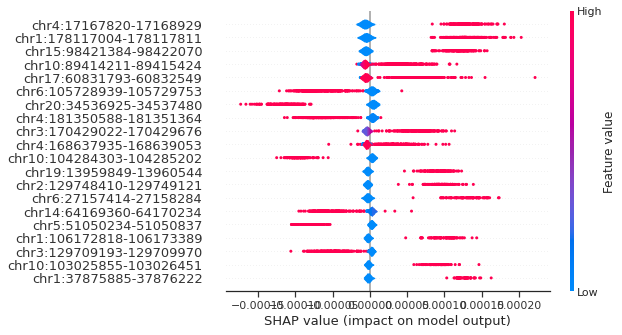

In [25]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

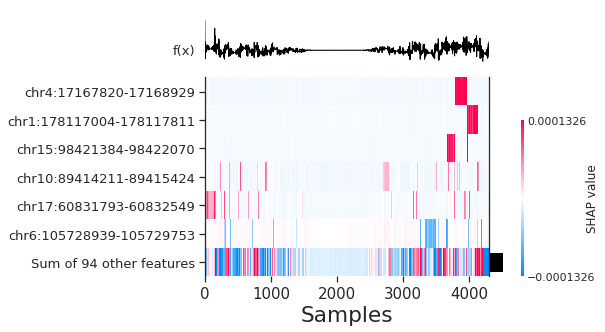

In [26]:
plt.figure(figsize=(10, 5))
shap.plots.heatmap(shap_values, max_display=7, show=False)  # 7 because problem with visualization and tight layout
plt.gca().set_xlabel('Samples')
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

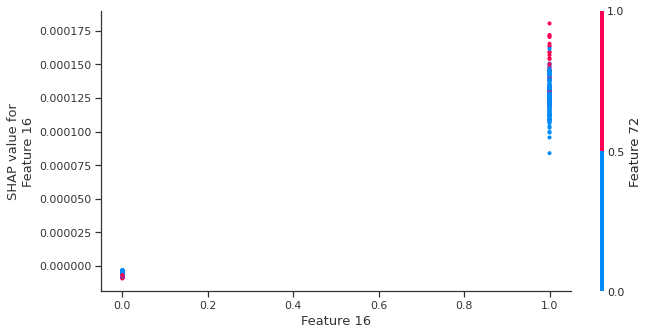

In [27]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

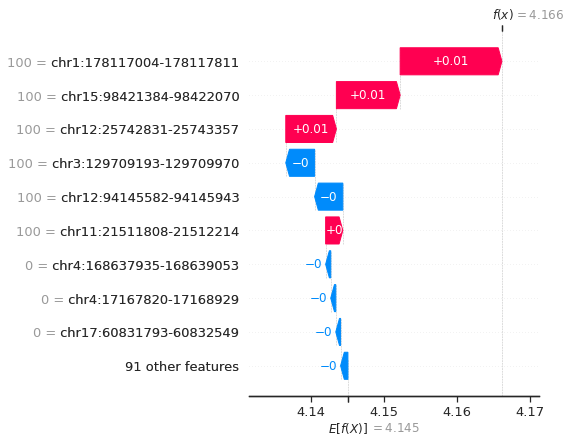

In [28]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.plots.waterfall(100*shap_values[0], show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Waterfall1.png');

### Interactive

In [ ]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [ ]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [ ]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)